<a href="https://colab.research.google.com/github/kay-squared/PyTorchLearn/blob/main/01_PyTorch_Workflow_runtimeAgnostic_video.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 5.1 import stuff

In [26]:
import torch
from torch import nn
import matplotlib.pyplot as plt
torch.__version__

'1.13.0+cu116'

### 5.2 Device agnostic code

In [27]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
#!nvidia-smi

cuda


### 5.3 Data


In [28]:
predictions=[]
X=[]
y=[]
X_train=[]
X_test=[]
y_train=[]
y_test=[]

weight = 0.2
bias = 0.1

start =-1
end=1
step=0.02

X = torch.arange(start,end+step,step).unsqueeze(dim=1)
y = weight * X + bias

train_split = int(0.8*len(X))
X_train, y_train = X[:train_split],y[:train_split]
X_test, y_test= X[train_split:],y[train_split:]

#plot_predictions(X_train,y_train,X_test,y_test)

In [29]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
  """
  Plots training data and test data and compares predictions
  """
  plt.figure(figsize=(10,7))
  plt.scatter(train_data,train_labels,c="b",s=4, label="Training data")
  plt.scatter(test_data,test_labels,c="orange",s=4, label="Test data")

  if predictions is not None:       # for the test data!
    plt.scatter(test_data,predictions,c="r",s=4,label="Predictions")
  
  plt.legend(prop={"size":14})


def plot_learning_curve(epoch_count, loss_train_list, loss_test_list):
  plt.figure(figsize=(10,7))
  plt.plot(epoch_count,loss_train_list,c="b", label="Training loss")
  plt.plot(epoch_count,loss_test_list,c="orange", label="Test loss")
  plt.legend(prop={"size": 14})

#plot_learning_curve(epoch_count, loss_train_list, loss_test_list)

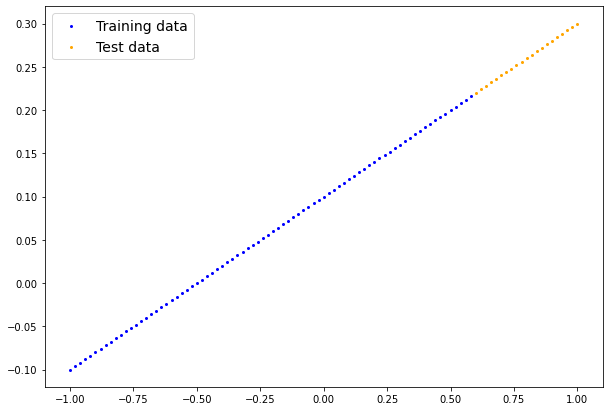

In [30]:
plot_predictions(X_train,y_train,X_test,y_test)

### Put data on target device

In [31]:
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

### 5.4 Build model

We are changing the manual initialization to a nn built in layer initialization. a linear layer create the parameters for a linear regression model in the background.




In [32]:


class LinearRegressionModelV2(nn.Module):
  def __init__(self):
    super().__init__()

    '''
    use a new method for initializing parameters
    initialize layers that have the parameters
    instead of iniitializing the. parameters themselves
    self.weights = nn.Parameter(torch.randn(1,
                                            requires_grad=True,
                                            dtype=torch.float))
    self.bias = nn.Parameter(torch.randn(1,
                                         requires_grad=True,
                                         dtype=torch.float))

    def forward() is also changed
    '''
    self.linear_layer = nn.Linear(in_features = 1,
                                  out_features = 1)        # R --> R; one layer only.

  def forward(self,x:torch.Tensor) -> torch.Tensor: 
    return self.linear_layer(x)

In [33]:
torch.manual_seed(42)
model_1 = LinearRegressionModelV2()
model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
             ('linear_layer.bias', tensor([0.8300]))])

### Put model on target device

In [34]:
# set the model to use the target device
# although the runtime might be set to gpu, the parameters of the model still live on the cpu
print(next(model_1.parameters()).device)
model_1.to(device)
print(next(model_1.parameters()).device)

cpu
cuda:0


### 5.5 Build training and testinig loop

In [37]:
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params = model_1.parameters(),
                            lr=0.01
                            )

torch.manual_seed(42)
epochs = 1000



epoch_count=[]
train_loss_list=[]
test_loss_list=[]

for epoch in range(epochs):
    ### Training
    model_1.train() # train mode is on by default after construction

    # 1. Forward pass
    y_pred = model_1(X_train)

    # 2. Calculate loss
    train_loss = loss_fn(y_pred, y_train)

    # 3. Zero grad optimizer
    optimizer.zero_grad()

    # 4. Loss backward
    train_loss.backward()       # not that this has to match the variable name for the traininig loss!!!

    # 5. Step the optimizer
    optimizer.step()

  


    model_1.eval()
    with torch.inference_mode():
      if epoch%50==1: 
        y_pred_test = model_1(X_test)
        test_loss = loss_fn(y_pred_test,y_test)
        test_loss_list.append(test_loss.detach().cpu().numpy())
        epoch_count.append(epoch)
        train_loss_list.append(train_loss.detach().cpu().numpy())

        print(f"Epoch: {epoch} | Train_loss: {train_loss} | Test_loss: {test_loss}")
        




Epoch: 1 | Train_loss: 0.02854679338634014 | Test_loss: 0.07342612743377686
Epoch: 51 | Train_loss: 0.010141652077436447 | Test_loss: 0.0001001251584966667
Epoch: 101 | Train_loss: 0.010141652077436447 | Test_loss: 0.0001001251584966667
Epoch: 151 | Train_loss: 0.010141652077436447 | Test_loss: 0.0001001251584966667
Epoch: 201 | Train_loss: 0.010141652077436447 | Test_loss: 0.0001001251584966667
Epoch: 251 | Train_loss: 0.010141652077436447 | Test_loss: 0.0001001251584966667
Epoch: 301 | Train_loss: 0.010141652077436447 | Test_loss: 0.0001001251584966667
Epoch: 351 | Train_loss: 0.010141652077436447 | Test_loss: 0.0001001251584966667
Epoch: 401 | Train_loss: 0.010141652077436447 | Test_loss: 0.0001001251584966667
Epoch: 451 | Train_loss: 0.010141652077436447 | Test_loss: 0.0001001251584966667
Epoch: 501 | Train_loss: 0.010141652077436447 | Test_loss: 0.0001001251584966667
Epoch: 551 | Train_loss: 0.010141652077436447 | Test_loss: 0.0001001251584966667
Epoch: 601 | Train_loss: 0.0101416

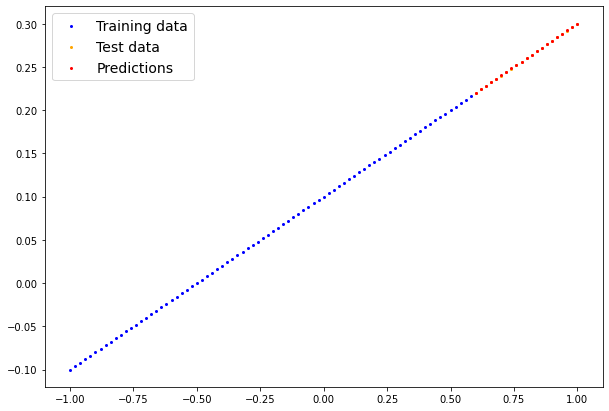

In [38]:
train_data = X_train.detach().cpu().numpy()
train_labels = y_train.detach().cpu().numpy()
test_data = X_test.detach().cpu().numpy()
test_labels = y_test.detach().cpu().numpy()
y_pred_test = model_1(X_test)

plot_predictions(train_data=train_data,
                 train_labels = train_labels,
                 test_data=test_data,
                 test_labels=test_labels,
                 predictions = y_pred_test.detach().cpu().numpy())


